# Xgboost Model for kaggle competition

## 0. Import the required packages

In [3]:
import numpy as np
import pandas as pd 
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='tab10')
%matplotlib inline

## 1. Data Preparation

### 1.1 load the data and see the basic information

In [4]:
# View train dataset and test dataset.
train=pd.read_csv('./data/train.csv',index_col='id')
print(train.info())
print(train.describe())
print('-'*50)
test=pd.read_csv('./data/test.csv',index_col='id')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14006 entries, 0 to 14005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    14006 non-null  object 
 1   speed   14006 non-null  float64
dtypes: float64(1), object(1)
memory usage: 328.3+ KB
None
              speed
count  14006.000000
mean      32.779118
std       13.573813
min        2.573417
25%       19.301089
50%       36.580595
75%       45.877665
max       53.161286
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3504 entries, 0 to 3503
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    3504 non-null   object
dtypes: object(1)
memory usage: 54.8+ KB
None


In [5]:
train.head()

,date,speed
id,,
0,1/1/2017 0:00,43.002930
1,1/1/2017 1:00,46.118696
2,1/1/2017 2:00,44.294158
3,1/1/2017 3:00,41.067468
4,1/1/2017 4:00,46.448653


### 1.2 View the distribution of speeds

[Text(0.5, 1.0, 'boxplot of speed')]

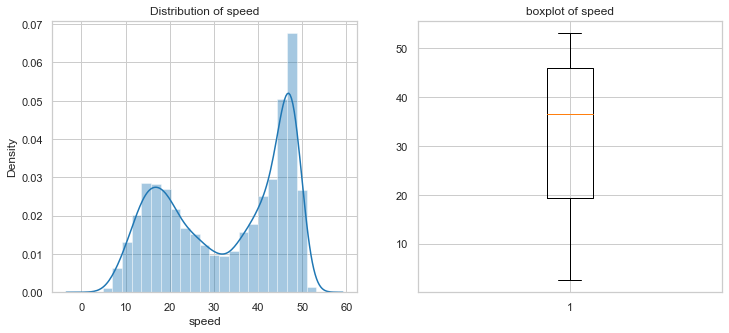

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
fig.set_size_inches(12,5)

sns.distplot(train['speed'],ax=ax1)
ax2.boxplot(train['speed'])
ax1.set(xlabel='speed',title='Distribution of speed')
ax2.set(title='boxplot of speed')

### 1.3 tranform the timestamp form

In [7]:
data=pd.concat([train,test],ignore_index=True)
data.rename(columns={'date': 'datetime'},inplace=True)

tmp=pd.to_datetime(data.datetime,format='%d/%m/%Y %H:%M')
data['date']=tmp.dt.date
data['year']=tmp.dt.year
data['quarter'] = tmp.dt.quarter
data['month']=tmp.dt.month
data['dayofyear'] = tmp.dt.dayofyear
data['weekofyear']=tmp.dt.weekofyear
data['day']=tmp.dt.day
data['hour']=tmp.dt.hour
data['weekday']=tmp.dt.weekday+1
data['ifweekend'] = (tmp.dt.weekday>5).astype(int)

data['ifholiday']=data.apply(lambda x: 1 if (
    x['date'] in [
           '2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04',
           '2017-04-14','2017-04-15','2017-04-17','2017-05-01','2017-05-03',
           '2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28',
           '2017-12-25','2017-12-26',
           '2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-03-30',
           '2018-03-31','2018-04-02','2018-04-05','2018-05-01','2018-05-22',
           '2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17',
           '2018-12-25','2018-12-26'
           ])
           or
    (x['weekday']==7) else 0, axis=1)

In [8]:
data.head()

,datetime,speed,date,year,quarter,month,dayofyear,weekofyear,day,hour,weekday,ifweekend,ifholiday
0,1/1/2017 0:00,43.002930,2017-01-01,2017,1,1,1,52,1,0,7,1,1
1,1/1/2017 1:00,46.118696,2017-01-01,2017,1,1,1,52,1,1,7,1,1
2,1/1/2017 2:00,44.294158,2017-01-01,2017,1,1,1,52,1,2,7,1,1
3,1/1/2017 3:00,41.067468,2017-01-01,2017,1,1,1,52,1,3,7,1,1
4,1/1/2017 4:00,46.448653,2017-01-01,2017,1,1,1,52,1,4,7,1,1


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17510 entries, 0 to 17509
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17510 non-null  object 
 1   speed       14006 non-null  float64
 2   date        17510 non-null  object 
 3   year        17510 non-null  int64  
 4   quarter     17510 non-null  int64  
 5   month       17510 non-null  int64  
 6   dayofyear   17510 non-null  int64  
 7   weekofyear  17510 non-null  int64  
 8   day         17510 non-null  int64  
 9   hour        17510 non-null  int64  
 10  weekday     17510 non-null  int64  
 11  ifweekend   17510 non-null  int32  
 12  ifholiday   17510 non-null  int64  
dtypes: float64(1), int32(1), int64(9), object(2)
memory usage: 1.7+ MB


### 1.4 Concatenate the weather data from http://www.worldweatheronline.com/

In [10]:
weather = pd.read_csv("./data/weather.csv")

In [11]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date_time          730 non-null    object 
 1   maxtempC           730 non-null    int64  
 2   mintempC           730 non-null    int64  
 3   totalSnow_cm       730 non-null    float64
 4   sunHour            730 non-null    float64
 5   uvIndex            730 non-null    int64  
 6   moon_illumination  730 non-null    int64  
 7   moonrise           730 non-null    object 
 8   moonset            730 non-null    object 
 9   sunrise            730 non-null    object 
 10  sunset             730 non-null    object 
 11  DewPointC          730 non-null    int64  
 12  FeelsLikeC         730 non-null    int64  
 13  HeatIndexC         730 non-null    int64  
 14  WindChillC         730 non-null    int64  
 15  WindGustKmph       730 non-null    int64  
 16  cloudcover         730 non

In [12]:
# drop the unuseful columns
weather = weather.drop(['totalSnow_cm','moon_illumination','moonrise', 'moonset','sunrise', 'sunset','location'], axis=1)

<AxesSubplot:>

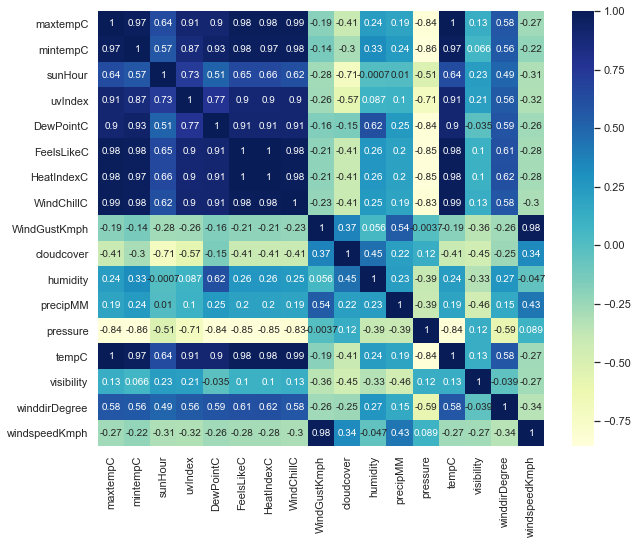

In [13]:
# plot the correlation matirx
plt.figure(figsize=(10,8))
sns.heatmap(weather.drop(['date_time'],axis=1).corr(), annot=True, cmap="YlGnBu")

In [14]:
# drop the highly correlated columns
weather = weather.drop(['DewPointC','FeelsLikeC','HeatIndexC', 'WindChillC','maxtempC', 'mintempC', 'WindGustKmph'], axis=1)

<AxesSubplot:>

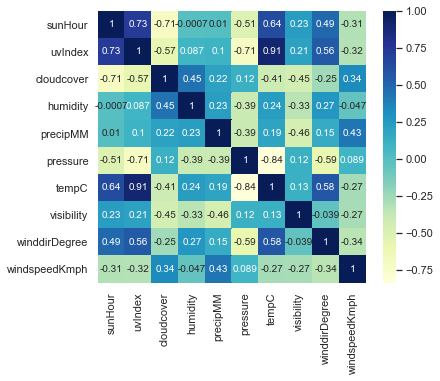

In [15]:
# plot the correlation matirx
plt.figure(figsize=(6,5))
sns.heatmap(weather.drop(['date_time'],axis=1).corr(), annot=True, cmap="YlGnBu")

In [16]:
weather.date_time = pd.to_datetime(weather.date_time,format='%Y-%m-%d').dt.date

In [17]:
all_data = pd.merge(data, weather, how='left', left_on='date', right_on='date_time')

In [18]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17510 entries, 0 to 17509
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       17510 non-null  object 
 1   speed          14006 non-null  float64
 2   date           17510 non-null  object 
 3   year           17510 non-null  int64  
 4   quarter        17510 non-null  int64  
 5   month          17510 non-null  int64  
 6   dayofyear      17510 non-null  int64  
 7   weekofyear     17510 non-null  int64  
 8   day            17510 non-null  int64  
 9   hour           17510 non-null  int64  
 10  weekday        17510 non-null  int64  
 11  ifweekend      17510 non-null  int32  
 12  ifholiday      17510 non-null  int64  
 13  date_time      17510 non-null  object 
 14  sunHour        17510 non-null  float64
 15  uvIndex        17510 non-null  int64  
 16  cloudcover     17510 non-null  int64  
 17  humidity       17510 non-null  int64  
 18  precip

In [19]:
train=all_data[all_data.speed.isnull()==False]

## 2. Feature Engineering

### 2.1 The effect of hour on speed (take average for the same hour)

Text(0.5, 1.0, 'The average speed per hour')

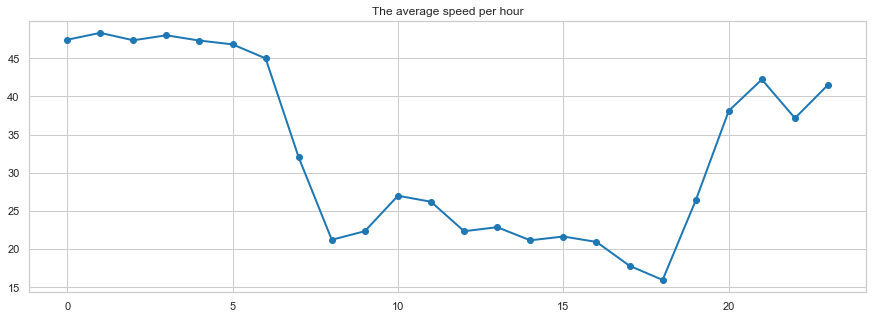

In [20]:
hour_df = train.groupby(['hour'], as_index=False).agg({'speed':'mean'})
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(hour_df['hour'] , hour_df['speed'],marker='o',linewidth=2)
ax.set_title('The average speed per hour')

### 2.2 The effect of weekday on speed (take average for the same hour)

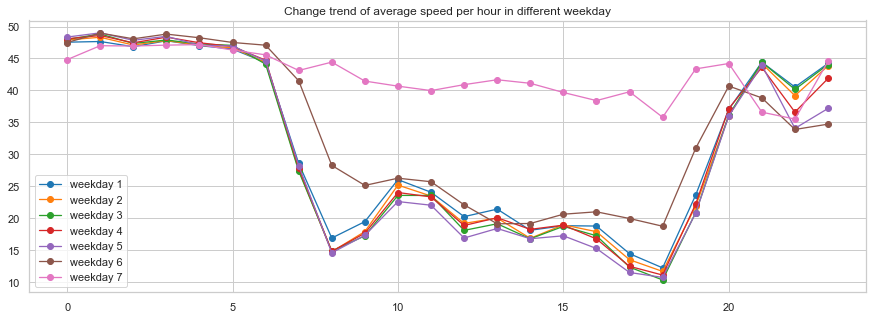

In [21]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

for i in range(1,8):
    saterday_df=train[train['weekday']==i]
    saterday_df = saterday_df.groupby(['hour'], as_index=False).agg({'speed':'mean'})
    ax.plot(saterday_df['hour'] , saterday_df['speed'] ,marker='o', linewidth=1.3 , label='weekday '+str(i))
    
ax.set_title('Change trend of average speed per hour in different weekday')
ax.legend()

# modes of Monday to Saturday are close, and mode of Sunday is different

### 2.3 The effect of holiday on speed (take average for the same hour)

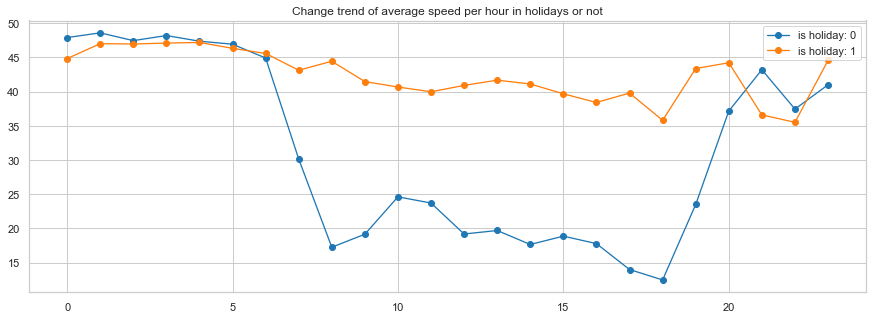

In [22]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)

for i in range(0,2):
    saterday_df=train[train['ifholiday']==i]
    saterday_df = saterday_df.groupby(['hour'], as_index=False).agg({'speed':'mean'})
    ax.plot(saterday_df['hour'] , saterday_df['speed'] ,marker='o', linewidth=1.3 , label='is holiday: '+str(i))
    
ax.set_title('Change trend of average speed per hour in holidays or not')
ax.legend()

### 2.4 The effect of date, month, weekday and year on speed

   year      speed
0  2017  32.619414
1  2018  32.983865


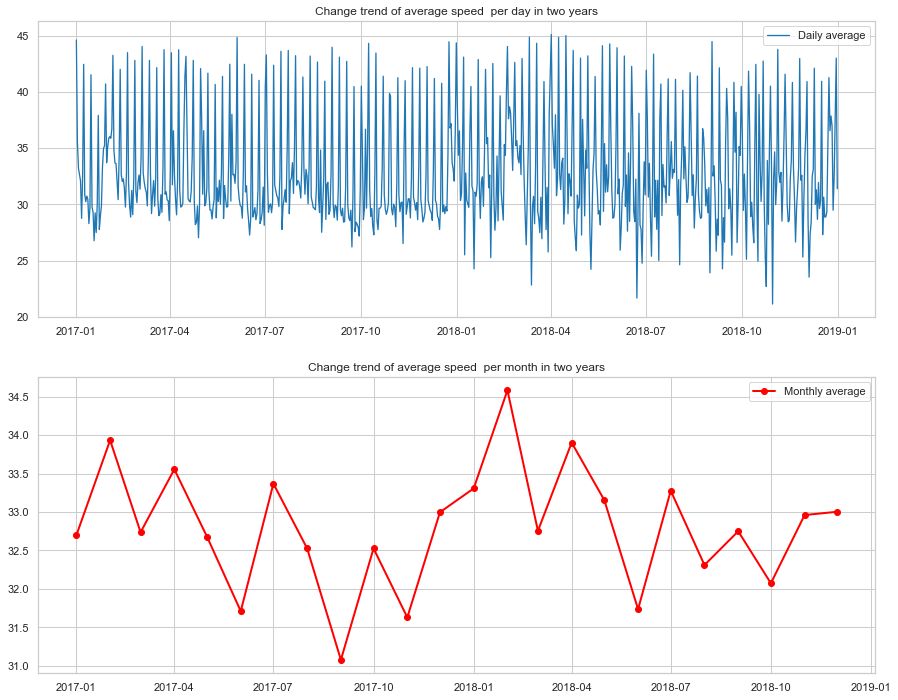

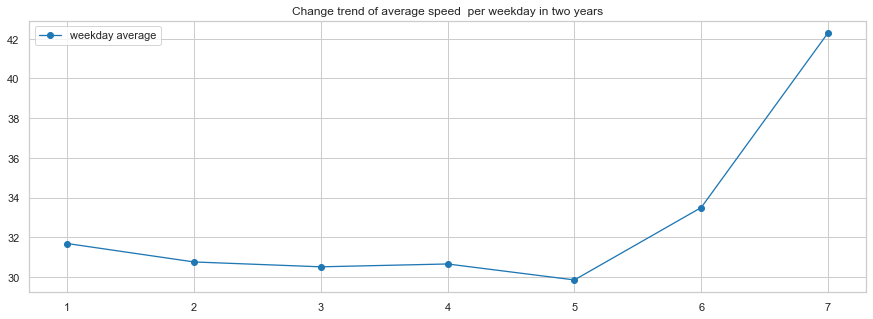

In [23]:
count_df = train.groupby(['date','weekday'], as_index=False).agg({'year':'mean',
                                                                      'month':'mean',
                                                                      'speed':'mean'})
count_df['date']=pd.to_datetime(count_df['date'])

count_month = count_df.groupby(['year','month'], as_index=False).agg({'weekday':'min',
                                                                      'speed':'mean'})
    
count_month.rename(columns={'weekday':'day'},inplace=True)
count_month['date']=pd.to_datetime(count_month[['year','month','day']])

fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

# Use a line chart to show the trend of speed over time
ax1.plot(count_df['date'] , count_df['speed'] , linewidth=1.3 , label='Daily average')
ax1.set_title('Change trend of average speed  per day in two years')
ax1.legend()

ax2.plot(count_month['date'] , count_month['speed'] , color='r',marker='o', linewidth=2 , label='Monthly average')
ax2.set_title('Change trend of average speed  per month in two years')
ax2.legend()

count_weekday= train.groupby(['weekday'], as_index=False).agg({'speed':'mean'})
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(count_weekday['weekday'] , count_weekday['speed'] ,marker='o', linewidth=1.3 , label='weekday average')
ax.set_title('Change trend of average speed  per weekday in two years')
ax.legend()

count_year = count_month.groupby(['year'], as_index=False).agg({'speed':'mean'})
print(count_year)

### 2.5 Feature Selection

In [24]:
all_data.columns

Index(['datetime', 'speed', 'date', 'year', 'quarter', 'month', 'dayofyear',
       'weekofyear', 'day', 'hour', 'weekday', 'ifweekend', 'ifholiday',
       'date_time', 'sunHour', 'uvIndex', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

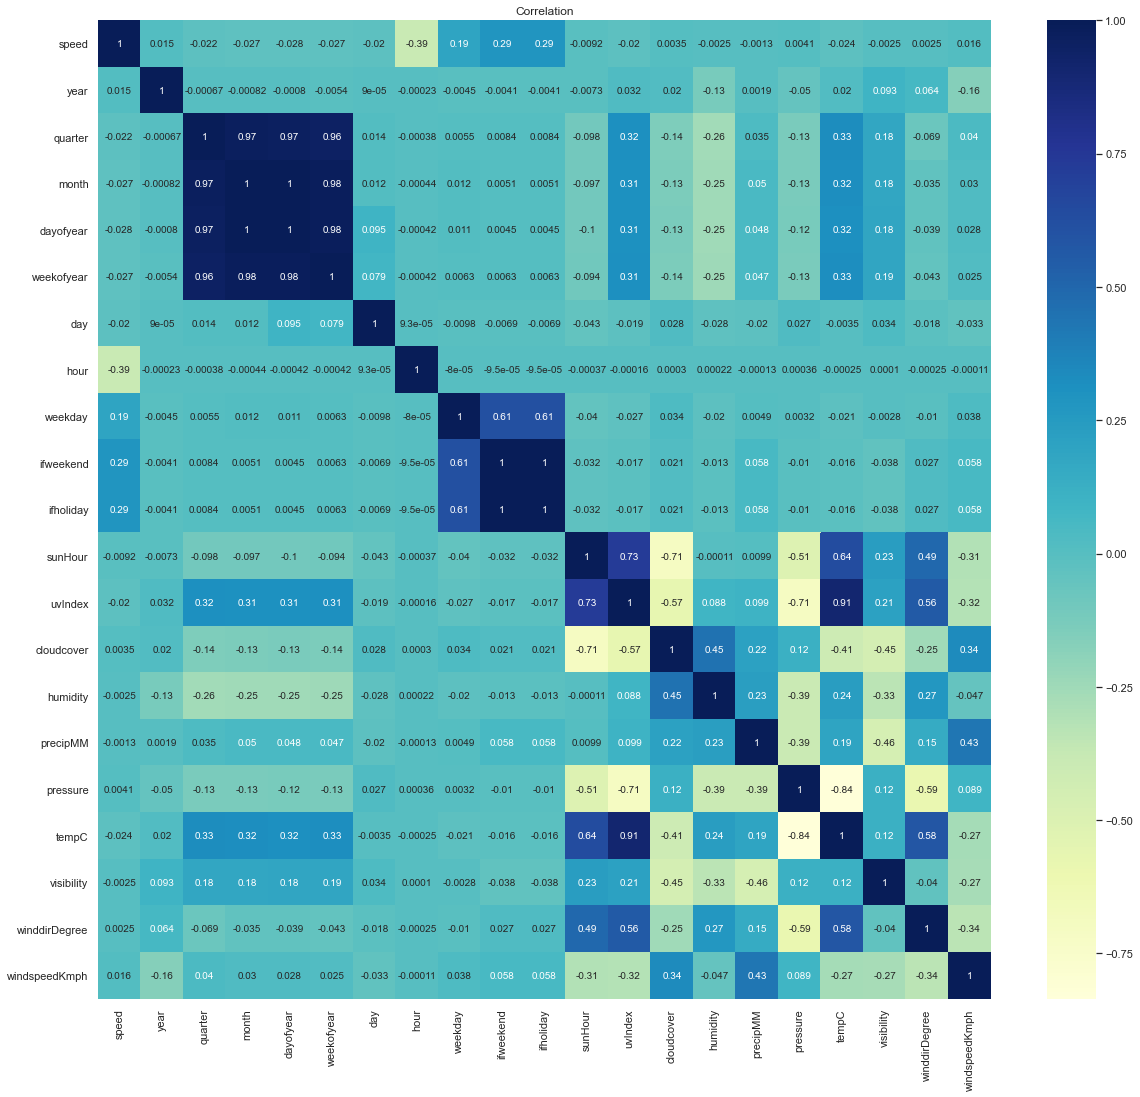

In [25]:
# plot the corr between features using heatmap
plt.figure(figsize = (20,18))

sns.heatmap(all_data.drop(['datetime','date'],axis=1).corr(), annot=True, cmap="YlGnBu")
plt.title('Correlation')
plt.show()

In [26]:
all_data.head()

,datetime,speed,date,year,quarter,month,dayofyear,weekofyear,day,hour,...,sunHour,uvIndex,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1/1/2017 0:00,43.002930,2017-01-01,2017,1,1,1,52,1,0,...,8.7,5,30,80,0.0,1021,21,10,76,16
1,1/1/2017 1:00,46.118696,2017-01-01,2017,1,1,1,52,1,1,...,8.7,5,30,80,0.0,1021,21,10,76,16
2,1/1/2017 2:00,44.294158,2017-01-01,2017,1,1,1,52,1,2,...,8.7,5,30,80,0.0,1021,21,10,76,16
3,1/1/2017 3:00,41.067468,2017-01-01,2017,1,1,1,52,1,3,...,8.7,5,30,80,0.0,1021,21,10,76,16
4,1/1/2017 4:00,46.448653,2017-01-01,2017,1,1,1,52,1,4,...,8.7,5,30,80,0.0,1021,21,10,76,16


In [27]:
# Separate training set and test set
train = all_data[pd.notnull(all_data['speed'])]
test= all_data[~pd.notnull(all_data['speed'])]
yLabels=train['speed']

In [28]:
train.columns

Index(['datetime', 'speed', 'date', 'year', 'quarter', 'month', 'dayofyear',
       'weekofyear', 'day', 'hour', 'weekday', 'ifweekend', 'ifholiday',
       'date_time', 'sunHour', 'uvIndex', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [29]:
# Discard unnecessary columns
dropFeatures = ['datetime' ,'speed', 'date','date_time',]

train = train.drop(dropFeatures , axis=1)
test = test.drop(dropFeatures , axis=1)

In [30]:
train.columns

Index(['year', 'quarter', 'month', 'dayofyear', 'weekofyear', 'day', 'hour',
       'weekday', 'ifweekend', 'ifholiday', 'sunHour', 'uvIndex', 'cloudcover',
       'humidity', 'precipMM', 'pressure', 'tempC', 'visibility',
       'winddirDegree', 'windspeedKmph'],
      dtype='object')

In [31]:
train.head()

,year,quarter,month,dayofyear,weekofyear,day,hour,weekday,ifweekend,ifholiday,sunHour,uvIndex,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,2017,1,1,1,52,1,0,7,1,1,8.7,5,30,80,0.0,1021,21,10,76,16
1,2017,1,1,1,52,1,1,7,1,1,8.7,5,30,80,0.0,1021,21,10,76,16
2,2017,1,1,1,52,1,2,7,1,1,8.7,5,30,80,0.0,1021,21,10,76,16
3,2017,1,1,1,52,1,3,7,1,1,8.7,5,30,80,0.0,1021,21,10,76,16
4,2017,1,1,1,52,1,4,7,1,1,8.7,5,30,80,0.0,1021,21,10,76,16


## 3. Model Training

In [32]:
X_train,X_test,y_train,y_test=train_test_split(train,yLabels,test_size=0.2,random_state=3)

tscv = TimeSeriesSplit(n_splits=10)
model = XGBRegressor()

param_grid = {'objective':['reg:squarederror'],
              'learning_rate':[0.03],
              'max_depth':[8],
              'min_child_weight':[5, 6, 7],
              'subsample':[0.85],
              'colsample_bytree':[0.80],
              'n_estimators':[600],
              'reg_lambda': [0.2]}

optimized_GBM = GridSearchCV(estimator=model,param_grid=param_grid,cv=tscv,n_jobs=-1)
optimized_GBM.fit(X_train,y_train)
print('The best value of the parameter: {0}'.format(optimized_GBM.best_params_))


The best value of the parameter: {'colsample_bytree': 0.8, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 6, 'n_estimators': 600, 'objective': 'reg:squarederror', 'reg_lambda': 0.2, 'subsample': 0.85}


In [33]:
# mse of train
y_train_pred = optimized_GBM.predict(X_train)
MSE_train = mean_squared_error(y_train_pred,y_train)
print('MSE for train set: '+str(MSE_train))

MSE for train set: 4.5970966731731195


In [34]:
# mse of validation
y_test_pred = optimized_GBM.predict(X_test)
MSE_test = mean_squared_error(y_test_pred,y_test)
print('MSE for validation set: '+str(MSE_test))

MSE for validation set: 10.186245283843423


## 4. Prediction in test dataset and save the result

In [35]:
y_test.shape

(2802,)

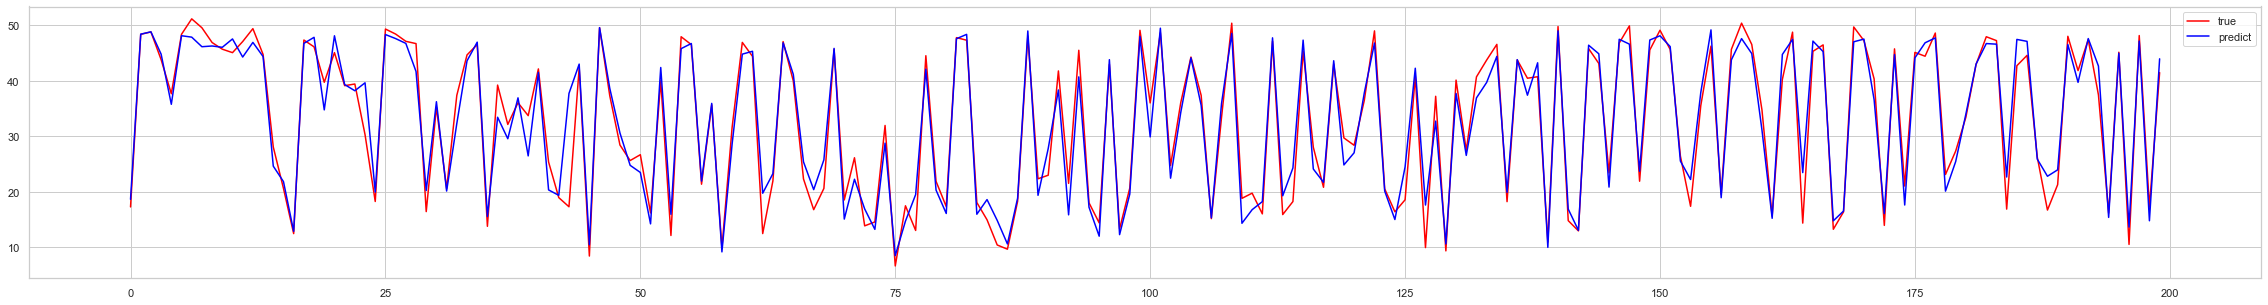

In [36]:
# vilisualization on validation set (here we only plot 200 points)

plt.figure(figsize=(40,5))
plt.plot(list(y_test)[:200],color='r',label='true')
plt.plot(y_test_pred[:200],color='b',label='predict')
plt.legend()

In [37]:
predsTest=optimized_GBM.predict(test)

In [38]:
pred=pd.DataFrame({'id': range(len(predsTest)), 'speed':predsTest},columns=['id','speed'])

In [39]:
pred

,id,speed
0,0,47.966923
1,1,47.679447
2,2,37.370922
3,3,29.969625
4,4,38.609322
...,...,...
3499,3499,13.092282
3500,3500,25.744732
3501,3501,47.212643
3502,3502,40.154041


In [40]:
pred.to_csv('./xgb_speed_prediction.csv',index=False)

## 5. Ensemble Xgboost model and SVT model
Here I do ensembling of Xgboost model and SVT model, so you may first run "SVT_model.ipynb" to get the predicted result of SVT model.

In [41]:
xgb = pd.read_csv("./xgb_speed_prediction.csv")
svt = pd.read_csv("./svt_speed_prediction.csv")

In [42]:
xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3504 non-null   int64  
 1   speed   3504 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.9 KB


In [43]:
svt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3504 entries, 0 to 3503
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3504 non-null   int64  
 1   speed   3504 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 54.9 KB


In [44]:
# Here I ensemble the two models by averaging their predicted speed.
xgb.speed = (xgb.speed +svt.speed)/2.0

In [45]:
xgb.head()

,id,speed
0,0,48.142479
1,1,47.801361
2,2,36.538812
3,3,30.005792
4,4,38.186352


In [46]:
xgb.to_csv("./ensemble_speed_prediction.csv", index=False)